<a href="https://colab.research.google.com/github/Florian-Debieve/datascience_projects/blob/main/cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
import random
assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.4 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In this project, the objectif, the goal is to develop an image classifier using the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The classes are completely mutually exclusive and are as follow: plane, car, bird, cat, deer, dog, frog, horse, ship and truck.

# **The Data**

Let's first get the data and separate it into a training, validation and test set.

In [6]:
(X_train_all, y_train_all), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_train_all = y_train_all.flatten()
y_test = np.array(y_test.flatten())

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=15)

170498071/170498071 [==============================] - 13s 0us/step


Let's now plot a few of the images from the dataset.

In [ ]:
class_names = {
    0: 'plane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

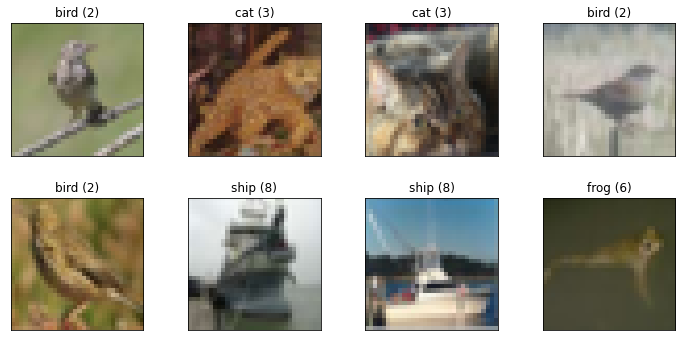

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(10,5))
fig.tight_layout()
row = [0,100,200,300,1000,1100,1200,1300]

for i, ax in enumerate(ax.flat):
    image = X_train[[row[i]]][0]
    ax.imshow(image)
    title = "{0} ({1})".format(class_names[y_train[[row[i]]][0]],y_train[[row[i]]][0])
    ax.set_title(title, fontsize = 12)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

# **Training a model**

For this project, we won't create neural networks from scratch. Instead, we'll use premade neural networks architecture with pre-trained weights.

Indeed, in Keras there are a number of applications that were made for the mageNet Large Scale Visual Recognition Challenge (ILSVRC). These applications have been trained and tested on a large image dataset as classifiers. As their functions are basically the same as in our goal, we can use them as a base for our models.

We will use the following applications:
- VGG16
- VGG19
- MobileNetV2
- ResNet101V2
- EfficientNetB7

It is important to note that for each of these application, it is necessary to preprocess the image accordingly to the application requirement. Functions are already implemented in Keras for this.

## Data augmentation

When you work with image, it is usually a good idea to make some data augmentation.

Here we are creating 3 tensorflow custom layers to add to our model during training that will modify randomly the inputed image. These layers will then be removed from the model after training as to not disturb the prediction.

The layers created are:
- RotateLayer: apply a slight rotation randomly to the image
- FlipHorizontallyRandom: has 50 % chance of applying a horzontal flip to the image
- RandomContrast: make a slight random modification to the color contrast of the image

In [16]:
class RotateLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RotateLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tfa.image.rotate(inputs, tf.random.uniform([1], -0.4, 0.4), fill_mode='reflect')

In [17]:
class FlipHorizontallyRandom(tf.keras.layers.Layer):
    def __init__(self, chance=0.5, **kwargs):
        super(FlipHorizontallyRandom, self).__init__(**kwargs)
        self.chance = chance
        
    def call(self, inputs):
        if tf.random.uniform([1])[0] < self.chance:
            return tf.image.flip_left_right(inputs)
        else:
            return inputs

In [18]:
class RandomContrast(tf.keras.layers.Layer):
    def __init__(self, min_factor=0.75, max_factor=1.25, **kwargs):
        super(RandomContrast, self).__init__(**kwargs)
        self.min_factor = min_factor
        self.max_factor = max_factor
        
    def call(self, inputs):
        contrast_factor = tf.squeeze(tf.random.uniform([1], self.min_factor, self.max_factor))
        return tf.image.adjust_contrast(inputs, contrast_factor)

## Training models


For the training, several layout were tested to see what was the most efficient. Some variation of hyperparameters were performed as well.
For each of the application, we'll used the pre-trained weights ("imagenet") and will allow further training.

Below are the 4 layouts explained layer by layer, the input layer being on the left and the output layer on the right. It is important to note that for every hidden dense layer, the activation function used is ReLu. As for the output layer we use the softmax function.

- Layout 1: Input: Pretrained application / Flatten layer / Dense Layer (4096 neurons) / Dense Layer (4096 neurons) / Output: Dense Layer (10 neurons)

- Layout 2: Input: Pretrained application / Global Average Pooling 2D layer / Dropout Layer (rate = 0.3) / Dense Layer (1000 neurons) / Output: Dense Layer (10 neurons)

- Layout 3: Input: Pretrained application / Global Average Pooling 2D layer / Dropout Layer (rate = 0.3) / Dense Layer (4000 neurons) / Dense Layer (4000 neurons) / Output: Dense Layer (10 neurons)

- Layout 4: Input: Pretrained application / Global Average Pooling 2D layer / Dense Layer (4000 neurons) / Dense Layer (4000 neurons) / Output: Dense Layer (10 neurons)

The method is as follow:
1. Preprocess the dataset depending on th application used.
2. Build the model on tensorflow and add the 3 data augmentation layers.
3. Running the training for 1 epoch with a varying learning rate and plotting the loss depending on the learning rate and choose the best value.
4. Training the model with an early stopping strategy depending on the validation loss.
5. Removing the 3 data augmentation data.
6. Test and save the model.

First we define the callback to make a varying learning rate.

In [10]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

Now, we preprocess the dataset.

In [ ]:
X_train_prep = tf.keras.applications.vgg16.preprocess_input(X_train)
X_valid_prep = tf.keras.applications.vgg16.preprocess_input(X_valid)
X_test_prep = tf.keras.applications.vgg16.preprocess_input(X_test)

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

We build the model.

In [ ]:
pretrained_model = tf.keras.applications.vgg16.VGG16(
    include_top=False ,
    weights='imagenet',
    input_shape=[32,32, 3]
)


model_ = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4000, activation='relu', kernel_initializer="he_normal", name='fc1'),
    tf.keras.layers.Dense(4000, activation='relu', kernel_initializer="he_normal", name='fc2'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model = tf.keras.Sequential([
    RotateLayer(input_shape=(32, 32, 3)),
    FlipHorizontallyRandom(),
    RandomContrast(),
    model_
])
    
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rotate_layer (RotateLayer)  (None, None, None, 3)     0         
                                                                 
 flip_horizontally_random (F  (None, None, None, 3)    0         
 lipHorizontallyRandom)                                          
                                                                 
 random_contrast (RandomCont  (None, None, None, 3)    0         
 rast)                                                           
                                                                 
 sequential (Sequential)     (None, 10)                32810698  
                                                                 
Total params: 32,810,698
Trainable params: 32,810,698
Non-trainable params: 0
___________________________________________

We run it for 1 epoch with the exponential learning rate callback (starting at 5e-6 with a factor of 1.014) so that during this epoch the learning rate go from 5e-6 to approximately 180.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-6),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

expon_lr = ExponentialLearningRate(factor=1.014)

history = model.fit(X_train_prep, y_train,
                    epochs=1,
                    validation_data=(X_valid_prep, y_valid),
                    callbacks=[expon_lr]
                    )

   6/1250 [..............................] - ETA: 1:05 - loss: 20.2624 - sparse_categorical_accuracy: 0.0833

1250/1250 [==============================] - 81s 56ms/step - loss: 17.7873 - sparse_categorical_accuracy: 0.1556 - val_loss: 177.8975 - val_sparse_categorical_accuracy: 0.1008


Then we plot the result:

Text(0, 0.5, 'Loss')

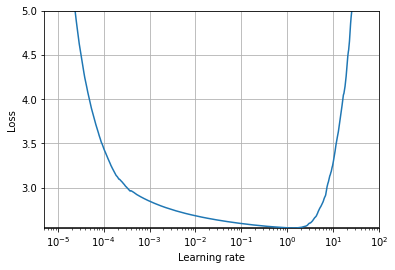

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), 100, min(expon_lr.losses), 5])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

On this graph we conclude that a good learning rate for this model would be 0.1

Then we train the model with the early stopping callback.

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-1),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
history = model.fit(X_train_prep, y_train,
                       epochs=35,
                    validation_data=(X_valid_prep, y_valid),
                    callbacks=[early_stopping_cb]
                    )

Now we get rid of the data augmentation layers so that there is no modification of the image during the prediction.

And we save it.

In [ ]:
sequential_layer = model.get_layer(model.layers[-1].name)

new_model = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),
    sequential_layer
])
new_model.save("/content/drive/MyDrive/ia/cifar_10/xxx", save_format="h5")
new_model.summary()

## Combining models to make an Ensemble

It always interesting to see if combining the prediction of several models improve the quality of the prediction.

As a result we create a function that will compute the prediction for the validation and test set giving a list of models that will compose the ensemble.

In [ ]:
def ensemble_prediction(models,valid,test,prep_func=[tf.keras.applications.vgg16.preprocess_input,tf.keras.applications.vgg19.preprocess_input,tf.keras.applications.efficientnet.preprocess_input]):
  true_valid = valid[1]
  true_test = test[1]
  input_valid = [f(valid[0]) for f in prep_func]
  input_test = [f(test[0]) for f in prep_func]
  pred_valid = [models[i].predict(input_valid[i]) for i in range(len(models))]
  pred_valid = np.stack(pred_valid, axis = 1)
  pred_valid = np.sum(pred_valid, axis=1)/ len(models)
  pred_test = [models[i].predict(input_test[i]) for i in range(len(models))]
  pred_test = np.stack(pred_test, axis = 1)
  pred_test = np.sum(pred_test, axis=1)/ len(models)
  return [np.argmax(pred_valid,1),np.argmax(pred_test,1)]

In [ ]:
predictions = ensemble_prediction([vgg16_v4,vgg19_v2,efficientnetb7_v4],[X_valid,y_valid],[X_test,y_test])

313/313 [==============================] - 154s 491ms/step


In [19]:
accuracy_val = accuracy_score(y_valid,predictions[0])
accuracy_test = accuracy_score(y_test,predictions[1])
print(accuracy_val,accuracy_test)

0.9126 0.9063


# **Analyzing the results**

In the DataFrame below, we have written the result gotten from some of the tests we have performed. In the "model" column", there are the names of the models that were trained. Except for the ensemble models, the version number (v1, v2, v3 or v4) correspond to the layout used (the layout meaning was explained previously in the file). We only put the models were the new version outperformed the previous one.


In [32]:
model_perf = pd.read_csv("/content/drive/MyDrive/ia/cifar_10/model_perf.csv", index_col=0)
model_perf

,model,preloaded_model,validation_accuracy,layout
0,vgg16_v1,vgg16,0.8521,layout_1
1,vgg19_v1,vgg19,0.8562,layout_1
2,resnet101V2_v1,resnet101V2,0.7733,layout_1
3,mobilenetV2_v1,mobilenetV2,0.7535,layout_1
4,efficientnet_v1,efficientnetb7,0.8414,layout_1
5,ensemble_v1,"vgg16_v1, vgg19_v1, efficientnet_v1",0.8882,ensemble
6,efficientnet_v2,efficientnetb7,0.8716,layout_2
7,vgg16_v3,vgg16,0.8819,layout_3
8,vgg19_v3,vgg19,0.8759,layout_3
9,ensemble_v2,"vgg16_v3, vgg19_v3, efficientnet_v2",0.9056,ensemble


During the first set of tests, we judged that it was not interesting to keep training models using the ResNet101V2 or the MobileNetV2 applications, as their results were not satisfactory enough.

For the models using VGG16 and VGG19 applications, the best layout was the third. And for the models using EfficientNetB7, the best layout was the fourth.

In the end, we put the 3 best models (vgg16_v3, vgg19_v3 and efficientnet_v4) into an ensemble (ensemble_v4) and tested its accuracy and obtained a validation accuracy of 0.9126 which was quite satisfactory. But the ensemble with only the vgg16_v3 model and the efficientnet_v4 model (ensemble_v4_bis) outperformed the former with a validation accuracy of 0.9160.

Being slightly better but also lighter and faster, as there are only 2 models in this ensemble, we decided to keep the ensemble_v4_bis.

The final step is to train the 3 model that will be kept (vgg16_v3, vgg19_v3, efficientnet_v4) with the validation data and then compute their prediction on the test set.

Now that the models on which we will rely on for the classification task have been decided, we can complete their training with the validation data and using the test data to monitor the loss during the training and stopping it when there is no more progress.

We get the following test accuracy values:

In [17]:
model_fin = pd.read_csv("/content/drive/MyDrive/ia/cifar_10/model_fin.csv", index_col=0)
model_fin

,model,test_accuracy
0,vgg16_v3,0.8850
1,efficientnet_v4,0.9018
2,ensemble_v4_bis,0.9121


It looks like the previous resluts gotten with the validation data are similar to the results with the test data. The final model (ensemble_v4_bis) can now be used to classify images to the 10 categories that it was trained on !